In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install rouge_score
!pip install pandas
!pip install tqdm
!pip install datasets evaluate transformers[sentencepiece]

In [3]:
import torch
import pandas as pd
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
from rouge_score import rouge_scorer
from tqdm import tqdm
import matplotlib.pyplot as plt
import datasets
from datasets import load_dataset
import collections
import numpy as np

In [4]:
# Load the original QA model


# model_name = "deepset/roberta-base-squad2"
model_name = 'valhalla/bart-large-finetuned-squadv1'
model_squad = AutoModelForQuestionAnswering.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# checkpoint_path = "/content/drive/MyDrive/Project_2.2_fine-tuning/roberta-finetuned-subjqa-movies/checkpoint-3040"
checkpoint_path = '/content/drive/MyDrive/Project_2.2_fine-tuning/bart-finetuned-subjqa-movies/checkpoint-2432'
model_tuned = AutoModelForQuestionAnswering.from_pretrained(checkpoint_path)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


In [5]:
# Import data:    SubjQA

df_val=pd.read_csv('/content/drive/MyDrive/Project_2.2_fine-tuning/dev.csv')

max_length = 384
stride = 128

In [6]:
df_val=df_val[['question','human_ans_indices','review','human_ans_spans']]

df_val['id']=np.linspace(0,len(df_val)-1,len(df_val))

df_val['id']=df_val['id'].astype(str)

df_val['answers']=df_val['human_ans_spans']

for i in range(0,len(df_val)):
  answer1={}
  si=int(df_val.iloc[i].human_ans_indices.split('(')[1].split(',')[0])
  ei=int(df_val.iloc[i].human_ans_indices.split('(')[1].split(',')[1].split(' ')[1].split(')')[0])
  answer1['text']=[df_val.iloc[i].review[si:ei]]
  answer1['answer_start']=[si]
  df_val.at[i, 'answers']=answer1
  # print(df_train.iloc[i].answers,df_train.iloc[i].human_ans_spans)

df_val.columns=['question', 'human_ans_indices', 'context', 'human_ans_spans','id',
       'answers']

In [7]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [8]:
val_dataset2 = datasets.Dataset.from_pandas(df_val)

In [9]:
val_dataset2

Dataset({
    features: ['question', 'human_ans_indices', 'context', 'human_ans_spans', 'id', 'answers'],
    num_rows: 278
})

In [10]:
validation_dataset = val_dataset2.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=val_dataset2.column_names,
)
len(validation_dataset)

Map:   0%|          | 0/278 [00:00<?, ? examples/s]

554

In [11]:
validation_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 554
})

In [16]:
import torch
import pandas as pd
from rouge_score import rouge_scorer

def get_rouge_scores(model, tokenizer, data):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    rouge_scores = pd.DataFrame(columns=['precision', 'recall', 'fmeasure'])
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    for example in data:
        input_ids = torch.tensor(example['input_ids'])
        attention_mask = torch.tensor(example['attention_mask'])
        example_id = example['example_id']

        # Generate predictions
        with torch.no_grad():
            outputs = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))

            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

        all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
        start_index = torch.argmax(start_logits.to(device))
        end_index = torch.argmax(end_logits.to(device))
        predicted_answer = tokenizer.decode(input_ids[start_index:end_index + 1], skip_special_tokens=True)

        if len(predicted_answer) == 0:
          predicted_answer = 'ANSWERNOTFOUND'

        # Retrieve reference answer from the original dataset using example_id
        example_indices = [i for i, ex_id in enumerate(val_dataset2['id']) if ex_id == example_id]
        reference_answer = val_dataset2['answers'][example_indices[0]]['text'][0]
        # print("REF: ", reference_answer)
        # print("PRED: ", predicted_answer)

        # Calculate ROUGE-L score
        scores = scorer.score(predicted_answer, reference_answer)
        rouge_scores.loc[len(rouge_scores)] = [scores['rougeL'].precision,
                                               scores['rougeL'].recall,
                                               scores['rougeL'].fmeasure]

    return rouge_scores

In [17]:
# Calculate ROUGE scores for the original model
tuned_rouge_scores = get_rouge_scores(model_tuned, tokenizer, validation_dataset)
squad_rouge_scores = get_rouge_scores(model_squad, tokenizer, validation_dataset)

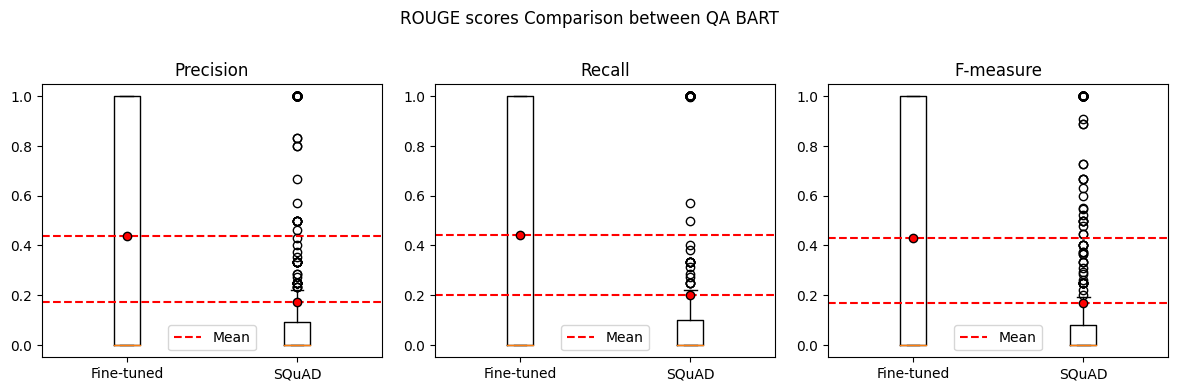

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the scores for each model
precision_tuned = tuned_rouge_scores['precision']
precision_squad = squad_rouge_scores['precision']

recall_tuned = tuned_rouge_scores['recall']
recall_squad = squad_rouge_scores['recall']

fmeasure_tuned = tuned_rouge_scores['fmeasure']
fmeasure_squad = squad_rouge_scores['fmeasure']

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Plot Precision with adjusted whiskers and individual data points
ax[0].boxplot([precision_tuned, precision_squad], sym='o', showmeans=True, meanprops={'marker': 'o', 'markeredgecolor': 'black', 'markerfacecolor': 'red'})
ax[0].set_xticklabels(["Fine-tuned", "SQuAD"])
ax[0].set_title('Precision')

# Plot Recall with adjusted whiskers and individual data points
ax[1].boxplot([recall_tuned, recall_squad], sym='o', showmeans=True, meanprops={'marker': 'o', 'markeredgecolor': 'black', 'markerfacecolor': 'red'})
ax[1].set_xticklabels(["Fine-tuned", "SQuAD"])
ax[1].set_title('Recall')

# Plot F-measure with adjusted whiskers and individual data points
ax[2].boxplot([fmeasure_tuned, fmeasure_squad], sym='o', showmeans=True, meanprops={'marker': 'o', 'markeredgecolor': 'black', 'markerfacecolor': 'red'})
ax[2].set_xticklabels(["Fine-tuned", "SQuAD"])
ax[2].set_title('F-measure')

# Set mean lines
mean_precision_tuned = np.mean(precision_tuned)
mean_precision_squad = np.mean(precision_squad)
ax[0].axhline(mean_precision_tuned, color='red', linestyle='--', label='Mean')
ax[0].axhline(mean_precision_squad, color='red', linestyle='--')
ax[0].legend()

mean_recall_tuned = np.mean(recall_tuned)
mean_recall_squad = np.mean(recall_squad)
ax[1].axhline(mean_recall_tuned, color='red', linestyle='--', label='Mean')
ax[1].axhline(mean_recall_squad, color='red', linestyle='--')
ax[1].legend()

mean_fmeasure_tuned = np.mean(fmeasure_tuned)
mean_fmeasure_squad = np.mean(fmeasure_squad)
ax[2].axhline(mean_fmeasure_tuned, color='red', linestyle='--', label='Mean')
ax[2].axhline(mean_fmeasure_squad, color='red', linestyle='--')
ax[2].legend()

# Set common title and adjust layout
fig.suptitle("ROUGE scores Comparison between QA BART")
fig.tight_layout(pad=1.5)

plt.show()


In [19]:
# Calculate overall scores
overall_precision_tuned = tuned_rouge_scores['precision'].mean()
overall_recall_tuned = tuned_rouge_scores['recall'].mean()
overall_fmeasure_tuned = tuned_rouge_scores['fmeasure'].mean()

# Print the overall scores
print("Fine-tuned")
print("Precision:", overall_precision_tuned)
print("Recall:", overall_recall_tuned)
print("F-measure:", overall_fmeasure_tuned)

overall_precision_squad = squad_rouge_scores['precision'].mean()
overall_recall_squad = squad_rouge_scores['recall'].mean()
overall_fmeasure_squad = squad_rouge_scores['fmeasure'].mean()

# Print the overall scores
print("SQuAD")
print("Precision:", overall_precision_squad)
print("Recall:", overall_recall_squad)
print("F-measure:", overall_fmeasure_squad)

Fine-tuned
Precision: 0.4379328887795828
Recall: 0.4427170584947613
F-measure: 0.429646892666898
SQuAD
Precision: 0.17285471847350628
Recall: 0.19982739685313952
F-measure: 0.16861500755378303


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

# Set marker size
marker_size = 3

# Plot Precision
sns.violinplot(data=[precision_tuned, precision_squad], ax=ax[0], inner="quartile")
sns.pointplot(data=[precision_tuned, precision_squad], ax=ax[0], color='red', markers='.', linestyles='', dodge=True, errorbar=None)
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(["Fine-tuned", "SQuAD"])
ax[0].set_title('Precision')

# Plot Recall
sns.violinplot(data=[recall_tuned, recall_squad], ax=ax[1], inner="quartile")
sns.pointplot(data=[recall_tuned, recall_squad], ax=ax[1], color='red', markers='.', linestyles='', dodge=True, errorbar=None)
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["Fine-tuned", "SQuAD"])
ax[1].set_title('Recall')

# Plot F-measure
sns.violinplot(data=[fmeasure_tuned, fmeasure_squad], ax=ax[2], inner="quartile")
sns.pointplot(data=[fmeasure_tuned, fmeasure_squad], ax=ax[2], color='red', markers='.', linestyles='', dodge=True, errorbar=None)
ax[2].set_xticks([0, 1])
ax[2].set_xticklabels(["Fine-tuned", "SQuAD"])
ax[2].set_title('F-measure')

# Set mean lines
mean_precision_tuned = np.mean(precision_tuned)
mean_precision_squad = np.mean(precision_squad)
ax[0].axhline(mean_precision_tuned, color='red', linestyle='--', label='Mean')
ax[0].axhline(mean_precision_squad, color='red', linestyle='--')
ax[0].legend()

mean_recall_tuned = np.mean(recall_tuned)
mean_recall_squad = np.mean(recall_squad)
ax[1].axhline(mean_recall_tuned, color='red', linestyle='--', label='Mean')
ax[1].axhline(mean_recall_squad, color='red', linestyle='--')
ax[1].legend()

mean_fmeasure_tuned = np.mean(fmeasure_tuned)
mean_fmeasure_squad = np.mean(fmeasure_squad)
ax[2].axhline(mean_fmeasure_tuned, color='red', linestyle='--', label='Mean')
ax[2].axhline(mean_fmeasure_squad, color='red', linestyle='--')
ax[2].legend()

# Set common title and adjust layout
fig.suptitle("ROUGE scores Comparison between QA BART")
fig.tight_layout(pad=1.5)

plt.show()
